In [1]:
#relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#momentum lib
from MomentumLibrary import *

#plotting
%matplotlib inline
sns.set()

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# General Strat
1. Fit a regression of asset on some explantory variable(s)
2. Determine if the asset is over/underprice relative to the historical relationship between the asset and the explantory variable

**Read in your asset price time series dataset**

In this case use the Brent Oil Futures

In [21]:
fullpath = f"../data/Brent Oil Futures Historical Data.csv" #dataset
df = pd.read_csv(fullpath)
df = clean(df)
df2 = transformDF(clean(df))[1]
df2.tail()

ADDED FEATURES - COMPLETE
--------------------


,Date,Price,Open,High,Low,Vol.,Change %,log_returns,IntradayRange,month_2,...,day_26,day_27,day_28,day_29,day_30,day_31,weekday_1,weekday_2,weekday_3,weekday_4
1355,2020-04-03,3.529591,3.397524,3.555348,3.341093,541.28K,13.93%,0.130395,0.214255,0,...,0,0,0,0,0,0,0,0,0,1
1356,2020-04-06,3.498022,3.458208,3.533395,3.402197,296.07K,-3.11%,-0.031569,0.131198,0,...,0,0,0,0,0,0,0,0,0,0
1357,2020-04-07,3.461665,3.516310,3.531641,3.457578,303.42K,-3.57%,-0.036356,0.074063,0,...,0,0,0,0,0,0,1,0,0,0
1358,2020-04-08,3.491647,3.485232,3.522530,3.451257,320.61K,3.04%,0.029982,0.071273,0,...,0,0,0,0,0,0,0,1,0,0
1359,2020-04-09,3.460095,3.520461,3.594019,3.445533,-,-3.11%,-0.031552,0.148486,0,...,0,0,0,0,0,0,0,0,1,0


**Read in your exogenous/explanatory/correlated variable time series dataset**

In this case we use US 10 Year Futures, give your exog features a unique name

In [22]:
#give your exog features a name
exog_name = 'US_10_Year_T_Note_Futures_Price'

exogenous = pd.read_csv('../data/US 10 Year T-Note Futures Historical Data.csv')
exogenous = exogenous[['Date','Price']]
exogenous = transformDF(clean(exogenous))[0]
exogenous.columns = ['Date',exog_name]+list(exogenous.columns[2:])

#this merges your exog and endog variables
df3 = pd.merge(df2,exogenous[['Date',exog_name]],how='inner',on='Date')
exogenous.tail()

ADDED FEATURES - COMPLETE
--------------------


,Date,US_10_Year_T_Note_Futures_Price,returns,log_returns,month,day,weekday
1387,2020-04-06,4.930220,-0.005247,-0.005260,4,6,0
1388,2020-04-07,4.926601,-0.003612,-0.003619,4,7,1
1389,2020-04-08,4.926094,-0.000508,-0.000508,4,8,2
1390,2020-04-09,4.928557,0.002467,0.002464,4,9,3
1391,2020-04-10,4.928485,-0.000072,-0.000072,4,10,4


**Select the features you want by Shift + Click**

In [23]:
featsToUse = makeWidget(df3,exog_name)
featsToUse

SelectMultiple(description='Variables', index=(53,), options=('Price', 'Open', 'High', 'Low', 'Vol.', 'Change …

**1. Fit a OLS**

**2. Determine if residuals deviate significantly using empirical CDF of all residuals**

invalid value encountered in greater_equal
invalid value encountered in less_equal


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     1173.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):          8.40e-186
Time:                        11:42:18   Log-Likelihood:                 572.24
No. Observations:                1358   AIC:                            -1140.
Df Residuals:                    1356   BIC:                            -1130.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              25.6138      0.630     40.646      0.000      24.378      26.850
US_10_Year_T_Note_Futures_Price    -4.4616      0.130    -34.255      0.000      -4.717      -4.206
==============================================================================
Omnibus:                      145.264   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.931
Skew:                          -0.804   Prob(JB):                     1.16e-45
Kurtosis:                       4.035   Cond. No.                         737.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

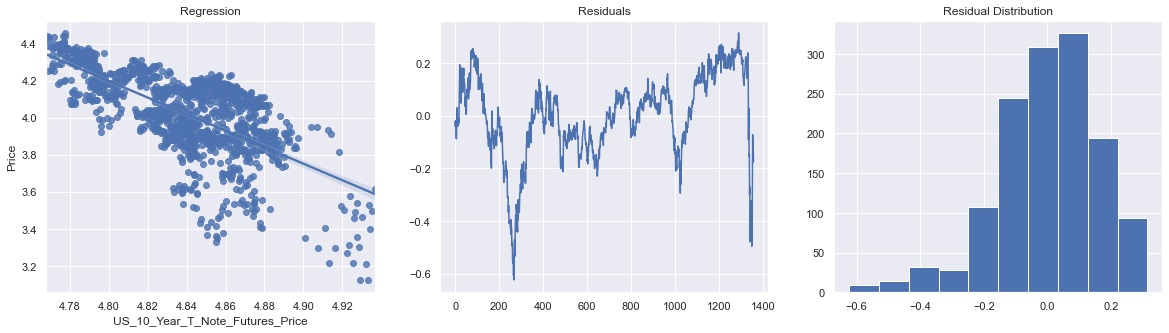

In [18]:
X = add_constant(df3[list(featsToUse.value)])
y = df3['Price'].shift(-1)
linear_reg = OLS(y.iloc[:-1],X.iloc[:-1]).fit()
fig, ax = plt.subplots(figsize=(20,5),ncols=3)
sns.regplot(X.iloc[:,1],y,ax=ax[0])
ax[1].plot((y-linear_reg.predict(X)))
ax[2].hist((y-linear_reg.predict(X)))
ax[0].set_title('Regression')
ax[1].set_title('Residuals')
ax[2].set_title('Residual Distribution')
linear_reg.summary()

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(y-linear_reg.predict(X))
residual = y.iloc[-2]-linear_reg.predict(X.iloc[-2].values)[0]
pval = ecdf(residual)
print("ANALYSIS")
print("------------------")
print(f"The residual of OLS fit is: {residual:.5f}")
print(f"The observed residual is in the {100*pval:.5f}% quintile")
if residual < 0.5:
    print(f"The last observed value ({np.exp(X.iloc[-2,1]):.2f}) of {datasets.value} is UNDERVALUED")
else:
    print(f"the last observed value of {datasets.value} OVERVALUED")
print(f"Based on FACTOR: {exog_name} ")

ANALYSIS
------------------
The residual of OLS fit is: -0.17530
The observed residual is in the 11.69978% quintile
The last observed value (137.84) of Brent Oil Futures is UNDERVALUED
Based on FACTOR: US_10_Year_T_Note_Futures_Price 
